In [1]:
import torch
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F

from fastai.distributed import *
from fastai.vision.all import *

from pathlib import Path
from functools import partial
import json
import pandas as pd
import matplotlib.pyplot as plt
import math


import ast

from PIL import Image

In [2]:
device = torch.device('cuda:0')
core_pth = Path('/home/agrawalp2/prepositions'); assert core_pth.exists()
spatialSenses_pth = core_pth/Path('real_world_data/spatialsense'); assert spatialSenses_pth.exists()
stupd_pth = Path('/mnt/dataset/agrawalp2/stupd_dataset'); assert stupd_pth.exists()

In [3]:
spatialsenses_to_stupd = {
    "above": "above",
    "behind": "behind",
    "in": "inside",
    "in front of": "in_front_of",
    "next to": "beside",
    "on": "on",
    "to the left of": "beside",
    "to the right of": "beside",
    "under": "below",
}

def map_spatialsenses_to_stupd(o, mapping_dict = spatialsenses_to_stupd):
    return spatialsenses_to_stupd[o]

def noop(x): return x

In [4]:
class SpatialDataset(Dataset):
    def __init__(self, split=None, 
                 annotations_path = spatialSenses_pth/'annotations.json', 
                 x_tfms: list = None,
                 y_tfms: list = None):
        
        super().__init__()
#         self.subjects = [] #x1
#         self.objects = [] #x2
        self.coords = []
        self.predicates = [] #y
        
        self.split = split
        if self.split is not None: assert split in ['train', 'valid', 'test'], f"invalid selection of split. expected values = 'train', 'valid', 'test'"
        
        self.classes = list(set(spatialsenses_to_stupd.values()))
        self.class2idx = {cat:i for i,cat in enumerate(self.classes)}
        self.idx2class = {self.class2idx[cat]:cat for cat in self.class2idx}
        self.c = len(self.classes)
        
        self.x_tfms = list(x_tfms or [noop]) 
        self.y_tfms = list(y_tfms or [noop]) + [lambda y: self.class2idx[y]]
        
        for relations in json.load(open(annotations_path)):
            if self.split and not relations["split"] == split: continue
            for relation in relations['annotations']:
                if not relation['label']: continue

                self.coords.append([relation['subject']['x'] - relation['object']['x'], relation['subject']['y'] - relation['object']['y'], 
                                    *relation['subject']['bbox'], 
                                    *relation['object']['bbox']])
#                 self.coords.append([relation['subject']['x'], relation['subject']['y'], relation['object']['x'], relation['object']['x']])
#                 self.coords.append([relation['subject']['x'] - relation['object']['x'], relation['subject']['y'] - relation['object']['y']])
                self.predicates.append(relation['predicate'])
    
    def __len__(self): return len(self.coords)
    def __getitem__(self, i):
        coord = self.apply_tfms(self.coords[i], self.x_tfms)
        predicate = self.apply_tfms(self.predicates[i], self.y_tfms)
        
        return (torch.Tensor(coord).type(torch.cuda.FloatTensor), 
                torch.Tensor([predicate]).type(torch.cuda.LongTensor))

    def apply_tfms(self, o, tfms):
        for tfm in tfms: o = tfm(o)
        return o

In [5]:
train_ds = SpatialDataset(split = 'train',
                         x_tfms = None,
                         y_tfms = [map_spatialsenses_to_stupd])

valid_ds = SpatialDataset(split = 'valid',
                         x_tfms = None,
                         y_tfms = [map_spatialsenses_to_stupd])

len(train_ds),len(valid_ds)

(5619, 1319)

In [6]:
train_dl = DataLoader(train_ds, batch_size =16 , shuffle = True, drop_last = True)
valid_dl = DataLoader(valid_ds, batch_size = 256 , shuffle = True, drop_last = True)

In [7]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, bn=True, relu=True):
        super().__init__()
        
        self.bn = bn
        self.relu = relu
        
        self.linear = nn.Linear(input_dim, output_dim)
        self.batchnorm = nn.BatchNorm1d(output_dim)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        x = self.linear(x)
        if self.bn: x = self.batchnorm(x)
        if self.relu: x = self.ReLU(x)
        return x
    
    
class SimpleCoordinateOnlyModel(nn.Module):
    def __init__(self, coord_len, feature_dim, c):
        super().__init__()

        self.layers = nn.Sequential(*[LinearBlock(coord_len, feature_dim)] + [LinearBlock(feature_dim, feature_dim) for _ in range(4)] + [nn.Linear(feature_dim, c)])
    
    def forward(self, x):
        return self.layers(x)

In [8]:
dls = DataLoaders(train_dl, valid_dl)
model = SimpleCoordinateOnlyModel(10, 64, train_ds.c).cuda()
learn = Learner(dls, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])

In [9]:
learn.fit(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.568954,1.504217,0.457031,0.315763,00:03
1,1.531300,1.472358,0.465625,0.324224,00:02
2,1.541894,1.460655,0.499219,0.378310,00:02
3,1.509629,1.473166,0.459375,0.354624,00:02
4,1.526597,1.470009,0.471094,0.369949,00:02
5,1.521170,1.433250,0.493750,0.368006,00:02
6,1.524947,1.460063,0.467187,0.342206,00:02
7,1.501352,1.450640,0.478125,0.345320,00:02
8,1.504029,1.436399,0.476562,0.368887,00:02
9,1.479694,1.450047,0.484375,0.373839,00:02


# Pretraining on stupd first

In [10]:
def convert_stupd_bbox_to_spatialsense_bbox(bbox):
    #stupd bbox format = wmin, hmin, w, h
    #spatialsenses bbox format = hmin, hmax, wmin, wmax
    
    wmin, hmin, w,h = bbox
    return (hmin, hmin+h, wmin, wmin+w)

In [11]:
class stupd(Dataset):
    def __init__(self, 
                 annotations_path = stupd_pth/'annotations', 
                 x_tfms: list = None,
                 y_tfms: list = None):
        
        super().__init__()
#         self.subjects = [] #x1
#         self.objects = [] #x2
        self.coords = []
        self.predicates = [] #y
        
        
        self.classes = list(set(spatialsenses_to_stupd.values()))
        self.class2idx = {cat:i for i,cat in enumerate(self.classes)}
        self.idx2class = {self.class2idx[cat]:cat for cat in self.class2idx}
        self.c = len(self.classes)
        
        self.x_tfms = list(x_tfms or [noop]) 
        self.y_tfms = list(y_tfms or [noop]) + [lambda y: self.class2idx[y]]

        for annotations in annotations_path.iterdir():
            
            if annotations.stem not in spatialsenses_to_stupd.values(): continue
            df = pd.read_csv(annotations).dropna()
            for i,row in df.iterrows():
                subj_3dcoords = ast.literal_eval(row['subject_position3d'])[0]
                obj_3dcoords = ast.literal_eval(row['object_position3d'])[0]
                subj_2dbbox = ast.literal_eval(row['subject_bbox2d'])[0]
                obj_2dbbox = ast.literal_eval(row['object_bbox2d'])[0]
                self.coords.append([subj_3dcoords['x'] -obj_3dcoords['x'], subj_3dcoords['y'] -obj_3dcoords['y'],
                                   *convert_stupd_bbox_to_spatialsense_bbox(subj_2dbbox),
                                   * convert_stupd_bbox_to_spatialsense_bbox(obj_2dbbox)])
                self.predicates.append(annotations.stem)
    
    def __len__(self): return len(self.coords)
    def __getitem__(self, i):
        coord = self.apply_tfms(self.coords[i], self.x_tfms)
        predicate = self.apply_tfms(self.predicates[i], self.y_tfms)
        
        return (torch.Tensor(coord).type(torch.cuda.FloatTensor), 
                torch.Tensor([predicate]).type(torch.cuda.LongTensor))

    def apply_tfms(self, o, tfms):
        for tfm in tfms: o = tfm(o)
        return o

In [12]:
ds = stupd()
len(ds)

34313

In [13]:
train_split = 0.8
train_ds, valid_ds = torch.utils.data.random_split(ds, [int(len(ds)*train_split), len(ds) - int(len(ds)*train_split)])
train_ds.c, valid_ds.c = 7,7

len(train_ds), len(valid_ds)

(27450, 6863)

In [14]:
train_dl = DataLoader(train_ds, batch_size =16 , shuffle = True, drop_last = True)
valid_dl = DataLoader(valid_ds, batch_size = 256 , shuffle = True, drop_last = True)

In [22]:
dls = DataLoaders(train_dl, valid_dl)
model = SimpleCoordinateOnlyModel(10, 64, train_ds.c).cuda()
learn = Learner(dls, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])

In [23]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.627927,0.471428,0.823017,0.822433,00:11
1,0.513339,0.409692,0.842849,0.841599,00:12
2,0.451219,0.384333,0.843750,0.844581,00:11


In [24]:
train_ds_spatialsenses = SpatialDataset(split = 'train',
                         x_tfms = None,
                         y_tfms = [map_spatialsenses_to_stupd])

valid_ds_spatialsenses = SpatialDataset(split = 'valid',
                         x_tfms = None,
                         y_tfms = [map_spatialsenses_to_stupd])

len(train_ds_spatialsenses),len(valid_ds_spatialsenses)

(5619, 1319)

In [25]:
train_dl_spatialsenses = DataLoader(train_ds_spatialsenses, batch_size =64 , shuffle = True)
valid_dl_spatialsenses = DataLoader(valid_ds_spatialsenses, batch_size = 128 , shuffle = False)
dls_spatialsenses = DataLoaders(train_dl_spatialsenses, valid_dl_spatialsenses)

SuggestedLRs(valley=0.019054606556892395)

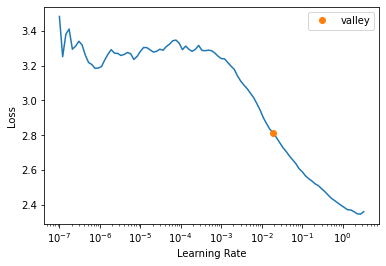

In [26]:
learn = Learner(dls_spatialsenses, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])
learn.lr_find()

In [27]:
learn.fit_one_cycle(20, 0.05) #had to run this twice to get 50.2 pct accuracy

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.650496,1.486557,0.473844,0.370369,00:00
1,1.562365,1.673597,0.407127,0.361877,00:00
2,1.544837,1.581982,0.401820,0.348902,00:00
3,1.548991,1.641278,0.401820,0.305892,00:00
4,1.540524,1.592286,0.429113,0.321775,00:00
5,1.520230,1.510691,0.482183,0.374637,00:00
6,1.506464,1.587167,0.426080,0.360241,00:00
7,1.503896,1.501997,0.463230,0.357858,00:00
8,1.503829,1.502060,0.449583,0.358936,00:00
9,1.485403,1.482254,0.475360,0.357762,00:00
